The problem
====
We are going to model rents by rational indivduals.

All quoted text is taken directly from the Macrobusiness website.

Setup
---


> At time=0 a city has 20 people in 10 homes owned by out-of-town investors.  1 person from each home earns 52,000 per year, the other is a dependent.  Rent for each home is 250 per week and each home is 100sqm in size.

Note that we are implicitly assuming that rent is 25% of income. An  assumption which is carried throughout. A really strong assumption throughout this analysis as that there is a certain percentage of income that people are willing to pay for accomodation. 


In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
cmap = pl.cm.Accent

class rent_model(object):
    """
    Class to allow easy interrorgating of rent state.
    """
    def __init__(self, num_people, incomes, num_houses, rent_ratio, house_size=100):
        """
        sets up the problem.
        Assumes that the rent ratio will remain the same.
        """
        self.num_houses = np.sum(num_houses)
        self.num_people=num_people
        incomes = np.array(incomes)
        if incomes.size == 1:
            incomes = incomes * np.ones((num_people/2))
        self.incomes = np.array(incomes)
        self.household_income = np.sum(incomes)/np.sum(num_houses)
        self.rents  = self.household_income*rent_ratio*np.ones(np.sum(num_houses))
        self.home_size = house_size * np.ones(np.sum(num_houses))
    
    def __str__(self):
        """
        Prints key object info as a string.
        """
        
        per_capita = np.sum(self.incomes)/self.incomes.size
        rent_to_income =100 * np.sum(self.rents)/np.sum(self.incomes)
        floor_space = np.sum(self.home_size)/float(self.num_people)
    
        output = 'rent_model: per capita = ${0:2}, rent to income = {1}% \n'.format(per_capita, rent_to_income)
    
        output = output + 'floor_space per person = {0:2.1f} m^2, average_weekly_rent = {1:2}\n'.format( floor_space, np.mean(self.rents)/52.0)
        output = output + 'average occupancy: {}\n'.format(self.num_people/float(np.sum(self.num_houses)))
        
        return output


model1 = rent_model(num_people=20, incomes=52000, num_houses=10, rent_ratio=0.25)
print model1

rent_model: per capita = $52000.0, rent to income = 25.0% 
floor_space per person = 50.0 m^2, average_weekly_rent = 250.0
average occupancy: 2.0



>Now, say supply is perfectly restricted. No new homes can be built at all, incomes remain constant but population increases 10%.

In [2]:
model2_supply_restricted = rent_model(num_people=20*1.1, incomes=52000, num_houses=10, rent_ratio=0.25)
print model2_supply_restricted

rent_model: per capita = $52000.0, rent to income = 25.0% 
floor_space per person = 45.5 m^2, average_weekly_rent = 275.0
average occupancy: 2.2



>There are now 11 income earners supporting 11 dependents.  Average occupancy must rise from 2 to 2.2 people per home.  Household income rises from $1,000 to $1,100 per week.  Rents will stay around 25% of incomes so now rent is $275 per week. Floor space is down from 50sqm to 45.5sqm per person. Rent paid per capita is the same.

>In this scenario what measures can signal a supply-side squeeze? Clearly we need to be looking at an increase in the rent to individual income and a decline in the sqm per person as evidence of a supply side squeeze.

>But once you introduce two more critical features to the model – geography and income distribution – things get very interesting.

Once again the assumption of 25% of income to rent comes in. What is the origin of this assumption?

> 
>Geography
---

>We can add geography to our toy model very easily by having the 10 identical homes on a single road heading away from the city centre.   They are equally spaced, and the marginal travel cost is $20 per week for each home as distance increases from the city.


>We must maintain the same averages as the previous model. In this scenario, average rents remain the same, but the cost of travel is bourne by all. With the total cost now 34% of incomes.

So travel cost seems to be added to the 25% income, but the extra convenience of being closer to the city is incorporated into the rents of the closer houses. This is how we get to the 34% of incomes.

rent_model: per capita = $52000.0, rent to income = 0.480769230769% 
floor_space per person = 50.0 m^2, average_weekly_rent = 4.80769230769
average occupancy: 2.0
rents = [ 340.  320.  300.  280.  260.  240.  220.  200.  180.  160.]
average rent = 250.0



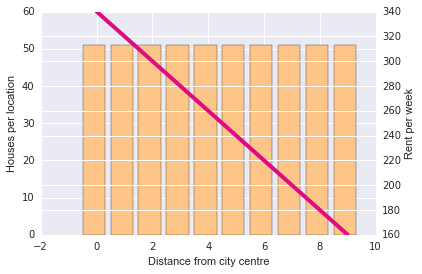

In [105]:
# Create new object to handle the geography and income disprarities.
# -- 

class rent_model_geo(rent_model):
    def __init__(self, num_people, incomes, num_houses, rent_ratio, 
                 house_size=100, travel_cost=20, max_housing_cost_ratio=0.34,
                 houses_per_location=None):
        self.travel_cost = travel_cost
        if houses_per_location is not None:                
            num_houses = np.sum(houses_per_location)
            self.houses_per_location = houses_per_location
        else:
            self.houses_per_location = num_houses * np.ones(10)
        rent_model.__init__(self, num_people=num_people, incomes=incomes, 
                            num_houses=num_houses, rent_ratio=rent_ratio)
        max_rent = self.household_income * max_housing_cost_ratio
        # To fix average rent, we set the most expensive rent and subtract.
        self.rents  = np.array([max_rent - i*travel_cost*52 
                                for i in range(0, self.houses_per_location.shape[0])])/float(52)
    def __str__(self):
        output = rent_model.__str__(self)
        output = output + 'rents = {}\n'.format(self.rents)
        output = output + 'average rent = {}\n'.format(np.mean(self.rents))
        return output
    
    def plot(self, title=''):
        pl.figure()
        num_houses = self.num_houses
        

        hist_x = np.arange(0, self.houses_per_location.shape[0], dtype=float) - 0.5
        hist_scale_fac = np.max(self.rents)*0.015
       
        pl.bar(hist_x, hist_scale_fac * self.houses_per_location, color=cmap(0.3))
        pl.xlabel('Distance from city centre')

        pl.ylabel('Houses per location')
        ax2 = pl.twinx()
        ax2.set_ylabel('Rent per week')

        house_location = range(0, self.houses_per_location.shape[0])
        pl.plot(house_location, 
                self.rents,  figure=ax2, linewidth=4, color=cmap(0.7))
        pl.title(title)
        
        
model3 = rent_model_geo(num_people=20, incomes=52000, num_houses=10, rent_ratio=0.25, max_housing_cost_ratio=0.34)
print model3
model3.plot()


Now lets consider what happens if we introduce new supply only in either the inner or outer half of the city. The key message here is that the rents do not change if we add new supply in either area.

rent_model: per capita = $52000.0, rent to income = 0.437062937063% 
floor_space per person = 45.5 m^2, average_weekly_rent = 4.80769230769
average occupancy: 2.0
rents = [ 340.  320.  300.  280.  260.  240.  220.  200.  180.  160.]
average rent = 250.0

rent_model: per capita = $52000.0, rent to income = 0.437062937063% 
floor_space per person = 50.0 m^2, average_weekly_rent = 4.80769230769
average occupancy: 2.0
rents = [ 340.  320.  300.  280.  260.  240.  220.  200.  180.  160.]
average rent = 250.0



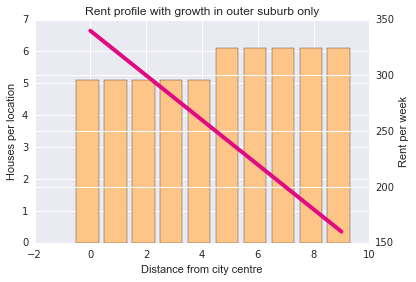

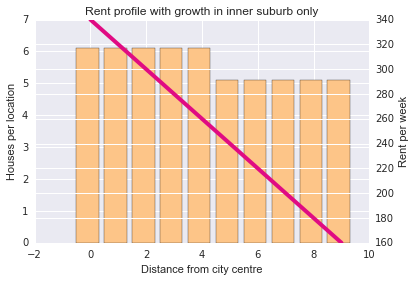

In [106]:
house_geo_outer = np.hstack((np.ones(5), 1.2*np.ones(5)))
model4 = rent_model_geo(num_people=20*1.1, incomes=52000, num_houses=10, 
                        houses_per_location=house_geo_outer, rent_ratio=0.25, 
                        max_housing_cost_ratio=0.34)
print (model4)
model4.plot()
pl.title('Rent profile with growth in outer suburb only')


house_geo_inner = np.hstack((1.2*np.ones(5), np.ones(5)))
model5 = rent_model_geo(num_people=20*1.1, incomes=52000, num_houses=10, 
                        houses_per_location=house_geo_inner, rent_ratio=0.25, 
                        max_housing_cost_ratio=0.34)
print model5
model5.plot()
pl.title('Rent profile with growth in inner suburb only')


>Income distribution
>===================

>If we add another dimension to this toy model in the form of a stylised income distribution. Income differences allow wealthier individuals to use their income to outbid for superior locations.

>Say the average individual still earns $52,000 per year ($1000pw), but that the wealthiest individual earns $125,000 and the poorest $13,400. Each household in between earns 80% of the previous household, starting at the wealthiest.

>We also convert the $20/week incremental commute cost to a commute-time cost based on the wage rate of each household.  Thus the commute cost to the first home costs $20 for the average income earner, but $48 of time for the high income earner, and just $5.17 for the lowest income earner.

So now we will have income inequality. We choose a linear model of income inequality that will work out to have a mean equal to $1000 per week. The rent of the closest house will be set by the richest persons willingness to pay, but the rent for the rest of the houses will be equal to the most expensive house minus the travel cost to that house. 

Notice that the average rent has now decreased, but we now will find some poorer people paying much more than 34% of their income for the house (even though the absolute value of the rent is low).



rent_model: per capita = $55789.1136, rent to income = 0.668768114425% 
floor_space per person = 50.0 m^2, average_weekly_rent = 7.17499621302
average occupancy: 2.0
rents = [817.30769230769238, 673.07692307692309, 538.46153846153845, 430.76923076923072, 344.61538461538458, 275.69230769230768, 220.55384615384617, 176.44307692307692, 141.15446153846156, 112.92356923076925]
average rent = 373.099803077

rent_model: per capita = $55789.1136, rent to income = 0.668768114425% 
floor_space per person = 45.5 m^2, average_weekly_rent = 7.17499621302
average occupancy: 2.0
rents = [817.30769230769238, 673.07692307692309, 538.46153846153845, 430.76923076923072, 344.61538461538458, 275.69230769230768, 220.55384615384617, 176.44307692307692, 141.15446153846156, 112.92356923076925]
average rent = 373.099803077



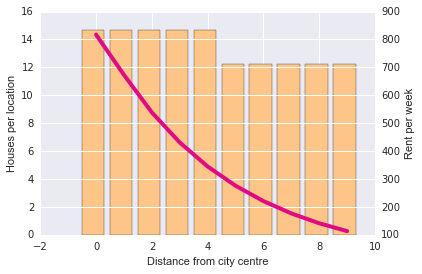

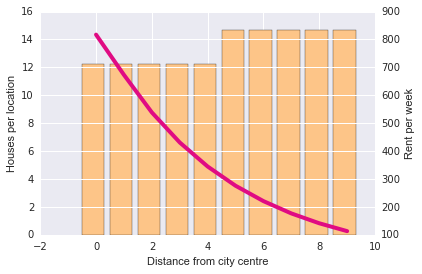

In [113]:
# Create a new object for the rent distributio
#
class rent_income_dist(rent_model_geo):
    """
    This class will also model rent income disparities
    The constructor doesn't need to change, but we can overload print analysis.
    """
    def __init__(self, num_people, incomes, num_houses, rent_ratio, 
                 house_size=100, travel_cost=20, max_housing_cost_ratio=0.34,
                 houses_per_location=None):
        super(rent_income_dist, self).__init__( num_people, incomes, num_houses, 
                                                   rent_ratio, house_size, travel_cost, 
                                                   max_housing_cost_ratio, houses_per_location)
        # We expect that self.income is a list of the income distribution per person
        
        # so we need to calculate what each person is willing to pay.
        # First calculate the proportion which is required.
        
        # Somewhat cheating here.
        self.per_week_ratio = np.linspace(48, 5.17, 10)
        # so the first house has no travel cost, and the richest person is willing to
        # pay 34% of their income for it.
        # Every house after this is bargained for, and the person whose travel cost is the greatest will
        # live in the next house.
        incomes = np.array(incomes,dtype=float)/52.0
        highest_rent = incomes[0]*0.34
        self.rents = [highest_rent]
        for i in range(1, len(incomes)):
            previous_house = self.rents[i-1]
            self.rents.append(incomes[i]*max_housing_cost_ratio)# + i*self.per_week_ratio[i])
        
        
house_geo_inner = np.hstack((1.2*np.ones(5), np.ones(5)))
incomes = [125000]
for i in range(1,10):
    incomes.append(incomes[i-1]*0.8)
model6 = rent_income_dist(num_people=20*1.1, incomes=incomes, 
                          num_houses=10,houses_per_location=house_geo_inner, 
                          rent_ratio=0.25, max_housing_cost_ratio=0.35)
model6.plot()
model7 = rent_income_dist(num_people=20*1.1, incomes=incomes, 
                          num_houses=10,houses_per_location=house_geo_outer, 
                          rent_ratio=0.25, max_housing_cost_ratio=0.35)
model7.plot()
print(model6)
print(model7)

>We see that the existence of income inequality actually increases the mean and median measures of rents, despite affordability being identical (34% of income on housing and commuting).  The only measure in this case that may indicate a supply constraint is the sqm per person.  Any other measure needs to properly control for income and geographical distributions.